# Message Analysis

In [1]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Need this to convert datetime objects in matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# TODO: fb messages, text messages, call log, whatsapp calls
# TODO: keep media
whatsapp = pd.read_csv('whatsapp_messages.csv')
whatsapp = whatsapp.drop(['UserPhone', 'QuotedMessage', 'QuotedMessageDate', 'QuotedMessageTime', 'MediaType', 'MediaLink'], axis=1)

with open('insta_messages.json', 'r') as f:
    json_str = f.read()
    first_conversation = json.loads(json_str)[0]['conversation']
    first_conversation_str = json.dumps(first_conversation)
    instagram = pd.read_json(first_conversation_str)
instagram = instagram.drop(['likes', 'link', 'media', 'media_owner', 'media_share_caption', 'media_share_url'], axis=1)

with open('fb_messages.json', 'r') as f:
    json_str = f.read()
    messages_json = json.loads(json_str)['messages']
    messages_str = json.dumps(messages_json)
    facebook = pd.read_json(messages_str)
facebook = facebook.drop(['gifs', 'photos', 'reactions', 'share', 'type'], axis=1)

In [3]:
print('Whatsapp messages:', len(whatsapp))
print('Instagram messages:', len(instagram))

Whatsapp messages: 6264
Instagram messages: 114


In [4]:
whatsapp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 5 columns):
Date1          56 non-null object
Date2          6264 non-null object
Time           6264 non-null object
UserName       6264 non-null object
MessageBody    6264 non-null object
dtypes: object(5)
memory usage: 244.8+ KB


In [5]:
instagram.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
created_at    114 non-null datetime64[ns]
sender        114 non-null object
text          109 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 2.8+ KB


In [6]:
facebook.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 3 columns):
content         243 non-null object
sender_name     245 non-null object
timestamp_ms    245 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 5.8+ KB


## Data Cleaning
Let's start the data cleaning up the date/time columns.

First, it looks like in our case all non-null rows of the `Date1` column have the same value as `Date2`, so let's drop `Date1` and rename `Date2`.

In [7]:
date1_neq_date2 = (~whatsapp['Date1'].isnull()) & (whatsapp['Date1'] != whatsapp['Date2'])

print('Number of rows where Date1 is not equal to Date2:', whatsapp[date1_neq_date2].shape[0])

Number of rows where Date1 is not equal to Date2: 0


In [8]:
# Consolidate Date1 and Date2
whatsapp = whatsapp.drop(['Date1'], axis=1)
whatsapp = whatsapp.rename(columns={'Date2': 'Date'})

In [9]:
# Combine date and time col to get full timestamp
whatsapp['Timestamp'] = whatsapp['Date'] + ' ' + whatsapp['Time']
whatsapp = whatsapp.drop(['Date', 'Time'], axis=1)

# Convert to date/time objects
datetime_cols = ['Timestamp']
for col in datetime_cols:
    whatsapp[col] = pd.to_datetime(whatsapp[col])

In [10]:
whatsapp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 3 columns):
UserName       6264 non-null object
MessageBody    6264 non-null object
Timestamp      6264 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 146.9+ KB


In [11]:
# TODO: keep name of source, eg. 'Instagram'
# Stack dataframes to make one big one to analyze

# Align dataframe columns
whatsapp = whatsapp[['Timestamp', 'UserName', 'MessageBody']]
facebook = facebook[['timestamp_ms', 'sender_name', 'content']]

# Give all dataframes uniform column names
all_dfs = [whatsapp, instagram, facebook]
for df in all_dfs:
    df.columns = ['Timestamp', 'UserName', 'Text']
    
df = pd.concat(all_dfs).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6623 entries, 0 to 6622
Data columns (total 3 columns):
Timestamp    6623 non-null datetime64[ns]
UserName     6623 non-null object
Text         6616 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 155.3+ KB


## Analysis

In [12]:
by_date = df.groupby([df['Timestamp'].dt.date])

# Daily Message Count
num_msgs_by_date = by_date['Text'].count()

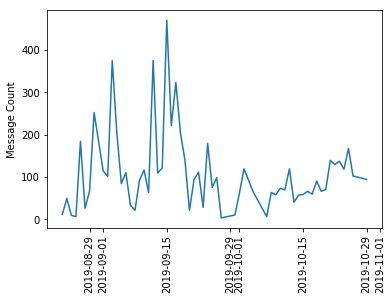

In [13]:
plt.plot(num_msgs_by_date)
plt.ylabel('Message Count')
plt.xticks(rotation=90)
plt.show()

In [14]:
# Cumulative messages by date
cumulative_messages = num_msgs_by_date.cumsum()

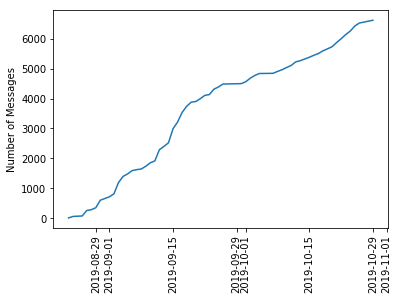

In [15]:
plt.plot(cumulative_messages)
plt.ylabel('Number of Messages')
plt.xticks(rotation=90)
plt.show()

In [16]:
terms_of_endearment = ['amor', 'amour', 'babe', 'baby', 'beautiful', 'chéri', 'chérie', 'handsome', 'honey', 'hottie', 'liebe', 'love', 'strawberry', 'shortcake', 'sleepy', 'sweety', 'sweetie', '❤️', '😘']
terms_of_laughter = ['lol', 'lmao', 'lmfao', 'haha', '😂', '🤣']

terms_of_endearment_regex = 'r' + '|'.join(terms_of_endearment)
terms_of_laughter_regex = 'r' + '|'.join(terms_of_laughter)

df['EndearmentScore'] = df['Text'].str.count(terms_of_endearment_regex)
df['LaughterScore'] = df['Text'].str.count(terms_of_laughter_regex)
df['WordCount'] = df['Text'].str.count(' ').add(1)  #Total number of words in that day

by_date_scores = df.groupby([df['Timestamp'].dt.date])

endearment_by_date = by_date_scores['EndearmentScore'].sum()
laugher_by_date = by_date_scores['LaughterScore'].sum()
wordcount_by_date = by_date_scores['WordCount'].sum()

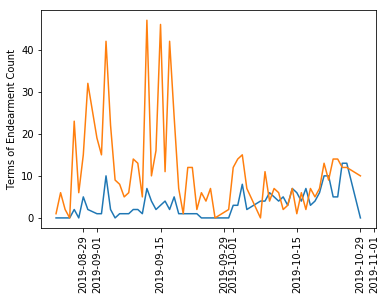

In [17]:
plt.plot(endearment_by_date)
plt.plot(laugher_by_date)
plt.ylabel('Terms of Endearment Count')
plt.xticks(rotation=90)
plt.show()